In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import os


In [ ]:
# Set workspace
workspace_path = r"C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master"
os.chdir(workspace_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master


In [ ]:
#Load Time Series Dataset from CSV
path = "data//artificialNoAnomaly//art_daily_small_noise.csv"
df = pd.read_csv(path)
time = df['timestamp']
demand = df['value'].values
df

df["timestamp"] = pd.to_datetime(df["timestamp"])  # Ensure proper datetime format
df.set_index("timestamp", inplace=True)  # Set as index


In [ ]:
#Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value"] = scaler.fit_transform(df[["value"]])

In [ ]:
#Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)


In [ ]:
#Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)


C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Forecast Future Values
predictions = model.predict(X)
df["forecast"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Detect Anomalies (Based on Forecast Error)
df["error"] = abs(df["value"] - df["forecast"])
threshold = df["error"].mean() + 1 * df["error"].std()  # Define anomaly threshold
df["anomaly"] = df["error"] > threshold


In [ ]:
# Anomaly Mitigation Interpolation**
df["smoothed_value"] = df["value"]
df.loc[df["anomaly"], "smoothed_value"] = np.nan  # Replace anomalies with NaN
df["smoothed_value"] = df["smoothed_value"].interpolate(method="time") #due to unexpected behavior decided to use time interpolation for all tests

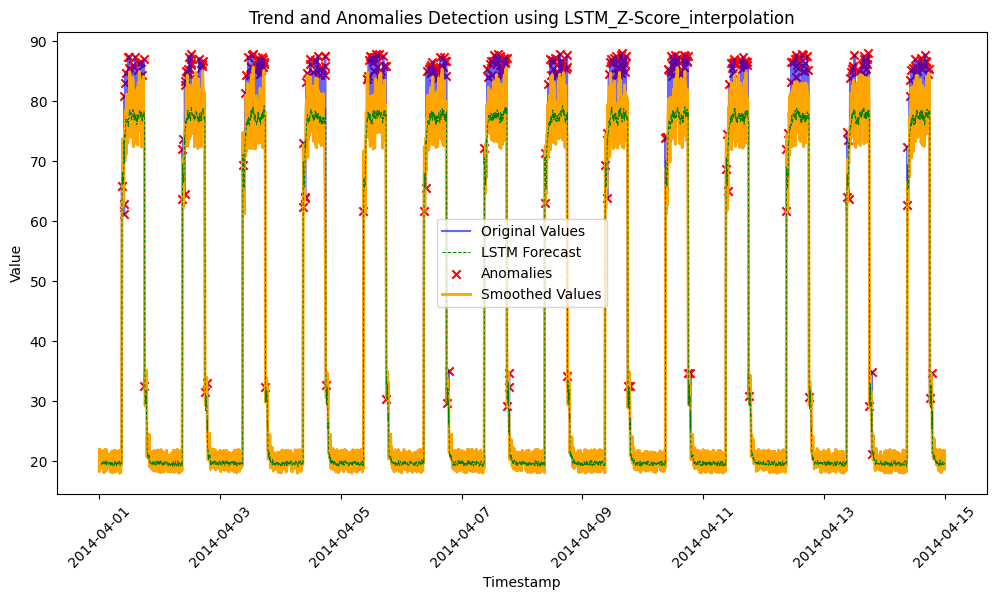

In [ ]:
#Plot Results
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["value"], label="Original Values", color="blue", alpha=0.6)
plt.plot(df.index, df["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", zorder =3, linewidth=0.7)
plt.scatter(df.index[df["anomaly"]], df["value"][df["anomaly"]], color="red", label="Anomalies", marker="x")
plt.plot(df.index, df["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2)
plt.legend()
plt.title("Trend and Anomalies Detection using LSTM_Z-Score_interpolation")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

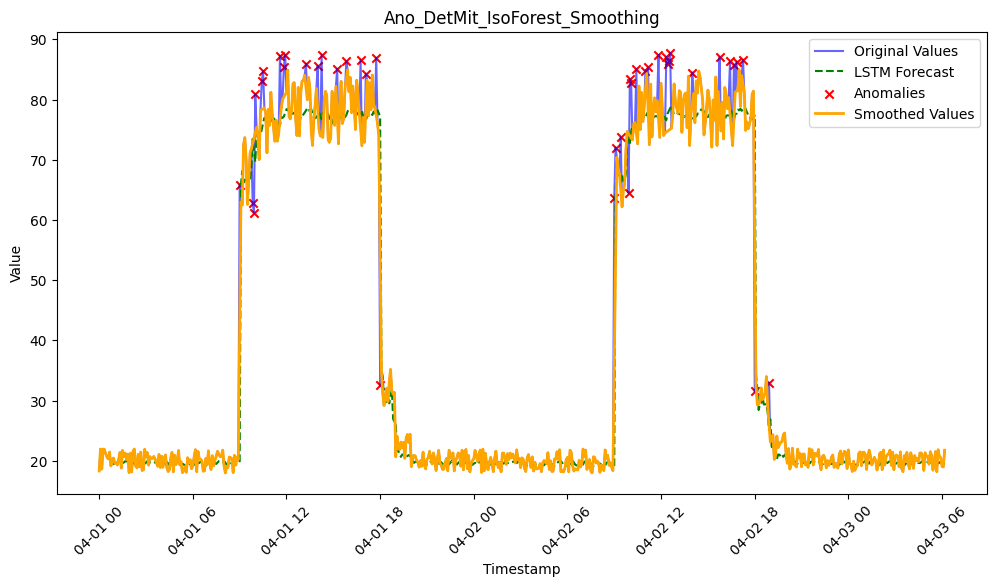

In [ ]:
# Filter the dataset for the specific date range
df_filtered = df.iloc[0:651]

# Plot only the filtered date range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=0.6)
plt.plot(df_filtered.index, df_filtered["forecast"], label="LSTM Forecast", linestyle="dashed", color="green")
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["value"][df_filtered["anomaly"]], color="red", label="Anomalies", marker="x")
plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2)
plt.legend()
plt.title("Trend and Anomalies Detection using LSTM_Z-Score_interpolation_filtered")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

In [73]:
print(df[df["anomaly"] == True])
print(len(df[df["anomaly"] == True]))

                         value  scaled_value   forecast      error  anomaly  \
timestamp                                                                     
2014-04-01 09:00:00  65.861141      0.683959  19.719982  46.141158     True   
2014-04-01 09:50:00  62.807773      0.640324  73.446068  10.638295     True   
2014-04-01 09:55:00  61.200418      0.617354  71.703011  10.502593     True   
2014-04-01 10:00:00  80.892367      0.898767  69.656425  11.235941     True   
2014-04-01 10:25:00  83.049859      0.929600  75.029762   8.020097     True   
...                        ...           ...        ...        ...      ...   
2014-04-14 16:40:00  86.747460      0.982441  77.354347   9.393113     True   
2014-04-14 17:25:00  84.511997      0.950495  77.202629   7.309368     True   
2014-04-14 17:45:00  85.417916      0.963441  78.264091   7.153824     True   
2014-04-14 18:00:00  30.553670      0.179388  77.883850  47.330181     True   
2014-04-14 18:55:00  34.704457      0.238706  25.282

In [ ]:
#Detect Anomalies (Based on Forecast Error)
df["error_smooth"] = abs(df["value"] - df["smoothed_value"])
threshold = df["error"].mean() + 1 * df["error"].std()  # Define anomaly threshold
df["smoothed_anomaly"] = df["error_smooth"] > threshold


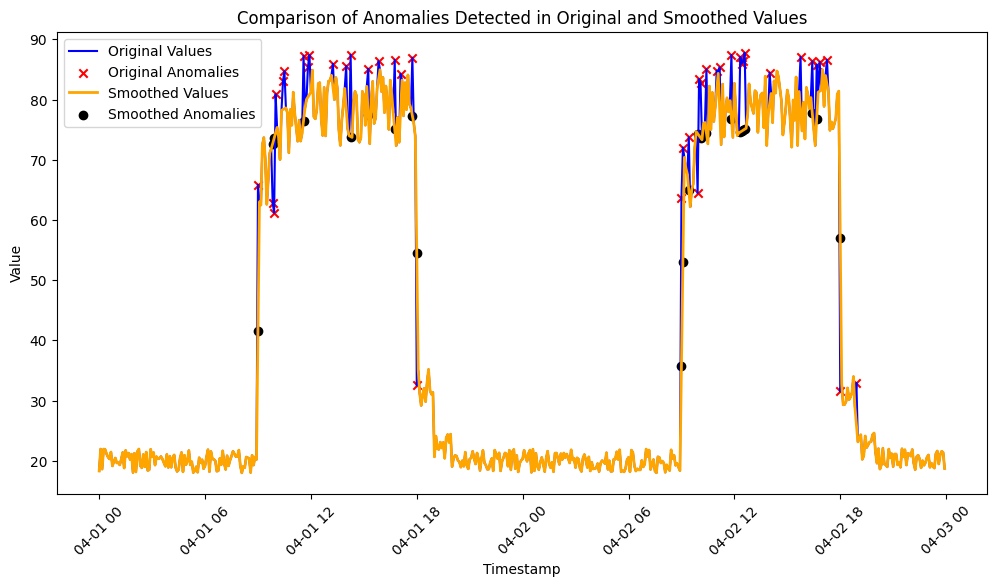

Original Anomalies Detected: 327
Smoothed Anomalies Detected: 219
Anomalies Reduced: 108


In [ ]:
start_date = "2014-04-01"
end_date = "2014-04-02"
df_filtered = df.loc[start_date:end_date]

plt.figure(figsize=(12, 6))

plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=1)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["value"][df_filtered["anomaly"]], color="red", label="Original Anomalies", marker="x")

plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Smoothed Values", color="orange", linewidth=2, zorder=3)
plt.scatter(df_filtered.index[df_filtered["smoothed_anomaly"]], df_filtered["smoothed_value"][df_filtered["smoothed_anomaly"]], color="black", label="Smoothed Anomalies", marker="o")

plt.title("Comparison of Anomalies Detected in Original and Smoothed Values")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

original_anomalies_count = df["anomaly"].sum()
smoothed_anomalies_count = df["smoothed_anomaly"].sum()

print(f"Original Anomalies Detected: {original_anomalies_count}")
print(f"Smoothed Anomalies Detected: {smoothed_anomalies_count}")
print(f"Anomalies Reduced: {original_anomalies_count - smoothed_anomalies_count}")

In [76]:
original_variance = np.var(df["value"])
smoothed_variance = np.var(df["smoothed_value"])

print(f"Original Variance: {original_variance:.4f}")
print(f"Smoothed Variance: {smoothed_variance:.4f}")
print(f"Variance Reduction: {original_variance - smoothed_variance:.4f}")

Original Variance: 788.1293
Smoothed Variance: 740.7956
Variance Reduction: 47.3337
